In [1]:
import numpy as np
import pandas as pd 
from numbers import Number
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
#Set Nan values of df.waterfront to 0
df.loc[df.waterfront.isna()==True, 'waterfront'] = 0

#Set all sqft_basement values of '?' to 0, then convert to floats.
df.loc[df.sqft_basement=='?', 'sqft_basement'] = 0
df.sqft_basement = df.sqft_basement.astype(float)

#Drop id, date, and view
cols_to_drop = ['id']
df.drop(cols_to_drop, axis=1, inplace=True)

In [5]:
df['date'] = pd.to_datetime(df['date'])
df['Month'] = df['date'].apply(lambda date: date.month)
df['Year'] = df['date'].apply(lambda date: date.year)
df['bathrooms'] = np.round(df['bathrooms'])
df['floors'] = np.round(df['floors'])

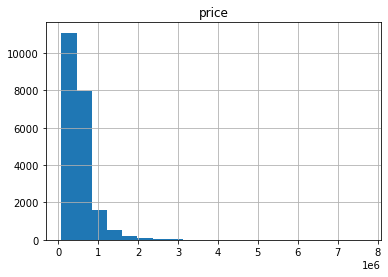

In [6]:
df.hist('price', bins=20);

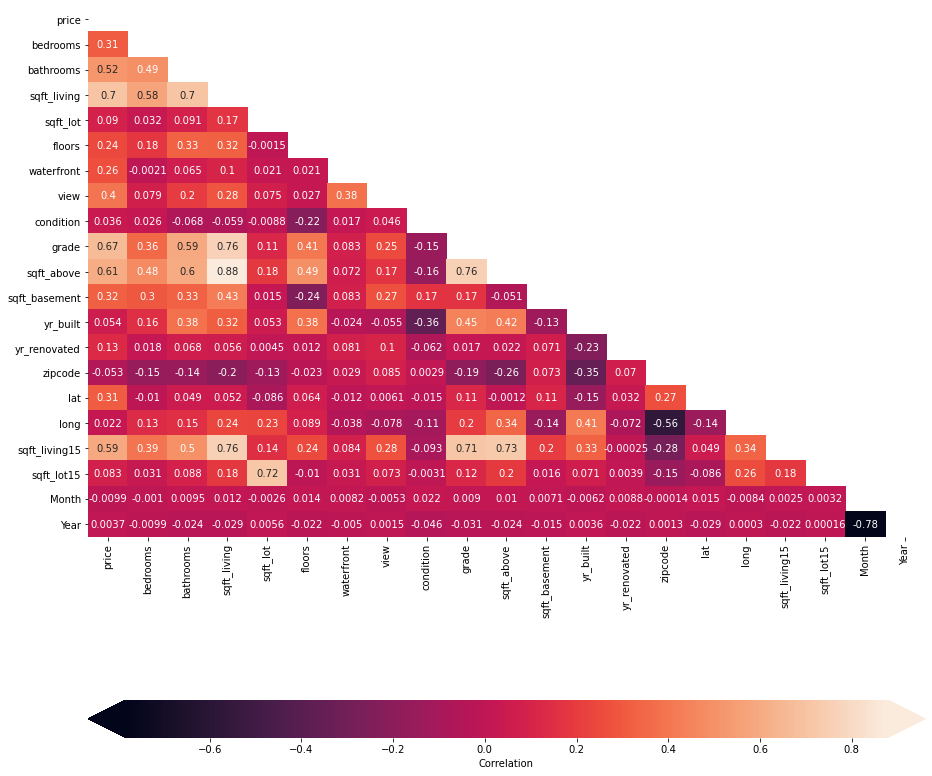

In [7]:
fig, ax = plt.subplots(figsize  =(15,15))
sns.heatmap(
            df.corr(), 
            ax=ax, 
            annot=True, 
            mask=np.triu(np.ones_like(df.corr(), dtype=bool)),
            cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
);

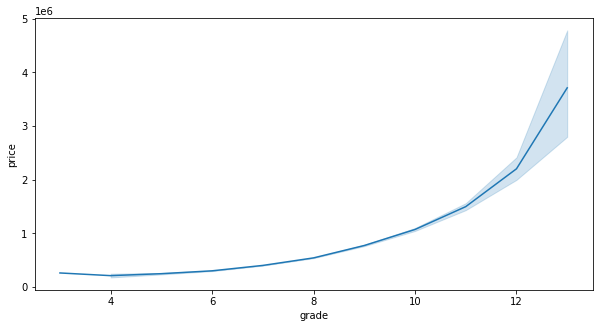

In [8]:
fig, ax = plt.subplots(figsize = (10,5))

sns.lineplot(x = 'grade', y = 'price', data = df);

The most correlated feature to price is sqft_living (.7).  We will use this feature to establish a baseline model.

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


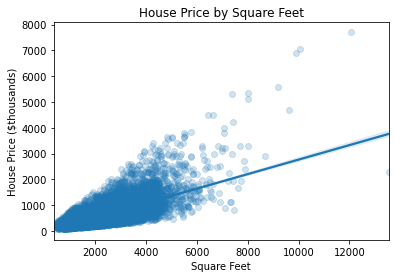

In [9]:
fig, ax = plt.subplots()

sns.regplot(df.sqft_living, df.price, scatter_kws={'alpha':0.2})

ax.set_xlabel('Square Feet')
ax.set_yticks(range(0,9000000,1000000))

ax.set_yticklabels(range(0,9000,1000))
ax.set_ylabel('House Price ($thousands)')

ax.set_title('House Price by Square Feet');

## Baseline Model

In [10]:
#Statsmodels
y = df.price
X = sm.add_constant(df.sqft_living)
stats_model_baseline = sm.OLS(endog=y, exog=X).fit()
stats_model_baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Mon, 12 Jul 2021   Prob (F-statistic):               0.00
Time:                        10:36:47   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

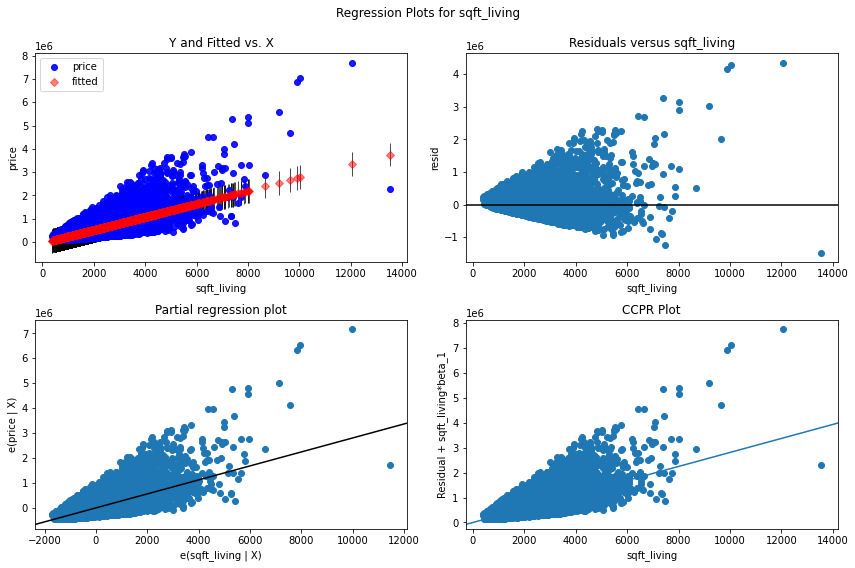

In [11]:
sm.graphics.plot_regress_exog(stats_model_baseline, 'sqft_living', fig = plt.figure(figsize=(12,8)));

In [12]:
#SkLearn
y = df.price
X = df.sqft_living.values.reshape(-1,1)
sk_model_baseline = LinearRegression()
sk_model_baseline.fit(X, y)
score = sk_model_baseline.score(X, y)
coef = sk_model_baseline.coef_
intercept = sk_model_baseline.intercept_
print('R2 score:              ', round(score, 3))
print('sqft_living coef.:     ', round(coef[0], 3))
print('Intercept:            ', round(intercept, 2))

R2 score:               0.493
sqft_living coef.:      280.863
Intercept:             -43988.89


In [13]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Month,Year
0,2014-10-13,221900.0,3,1.0,1180,5650,1.0,0.0,0.0,3,...,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,10,2014
1,2014-12-09,538000.0,3,2.0,2570,7242,2.0,0.0,0.0,3,...,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,12,2014
2,2015-02-25,180000.0,2,1.0,770,10000,1.0,0.0,0.0,3,...,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,2,2015
3,2014-12-09,604000.0,4,3.0,1960,5000,1.0,0.0,0.0,5,...,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,12,2014
4,2015-02-18,510000.0,3,2.0,1680,8080,1.0,0.0,0.0,3,...,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,2,2015


In [14]:
#Independent variable correlation table code

# df_corr = df.drop('price', axis=1).corr().stack().reset_index().sort_values(0, ascending=False)
# df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
# df_corr.set_index(['pairs'], inplace=True)
# df_corr.drop(columns=['level_0', 'level_1'], inplace=True)
# df_corr.columns = ['cc']
# df_corr
# # df_corr.drop_duplicates(inplace=True)
# # df_corr[(df_corr.cc > .75) & (df_corr.cc < 1)]

In [15]:
#VIF Factor code

# df_temp = sm.add_constant(df)

# vif = pd.DataFrame()
# vif["VIF Factor"] = [variance_inflation_factor(df_temp.values, i) for i in range(df_temp.values.shape[1])]
# vif["features"] = df_temp.columns
# print(vif.round(1))

In [17]:
#RFE Code

#X = df.drop(['price'], axis=1)
#y = df.price

#X_RFECV = StandardScaler().fit_transform(X)

#model_for_RFECV = LinearRegression()

#selector = RFECV(model_for_RFECV)
#selector.fit(X, y)

#print("Was the column selected?")
#for index, col in enumerate(X.columns):
#    print(f"{col}: {selector.support_[index], selector.ranking_[index]}")